# Загрузка и обработка данных

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c aimasters2022ml3hw4-license-plates

aimasters2022ml3hw4-license-plates.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip aimasters2022ml3hw4-license-plates.zip

Archive:  aimasters2022ml3hw4-license-plates.zip
replace submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import os
import cv2
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(1234)

In [8]:
path_train_simple = '/content/train/train/simple'
path_train_complex = '/content/train/train/complex'

In [9]:
config_train_simple = []
for item in os.listdir(path_train_simple):
    config_train_simple.append({"file": os.path.join(path_train_simple, item),
                              "text": item.split("_")[2][:-4]})

In [10]:
config_train_complex = []
for item in os.listdir(path_train_complex):
    config_train_complex.append({"file": os.path.join(path_train_complex, item),
                              "text": item.split("_")[2][:-4]})

Посмотрим на данные.

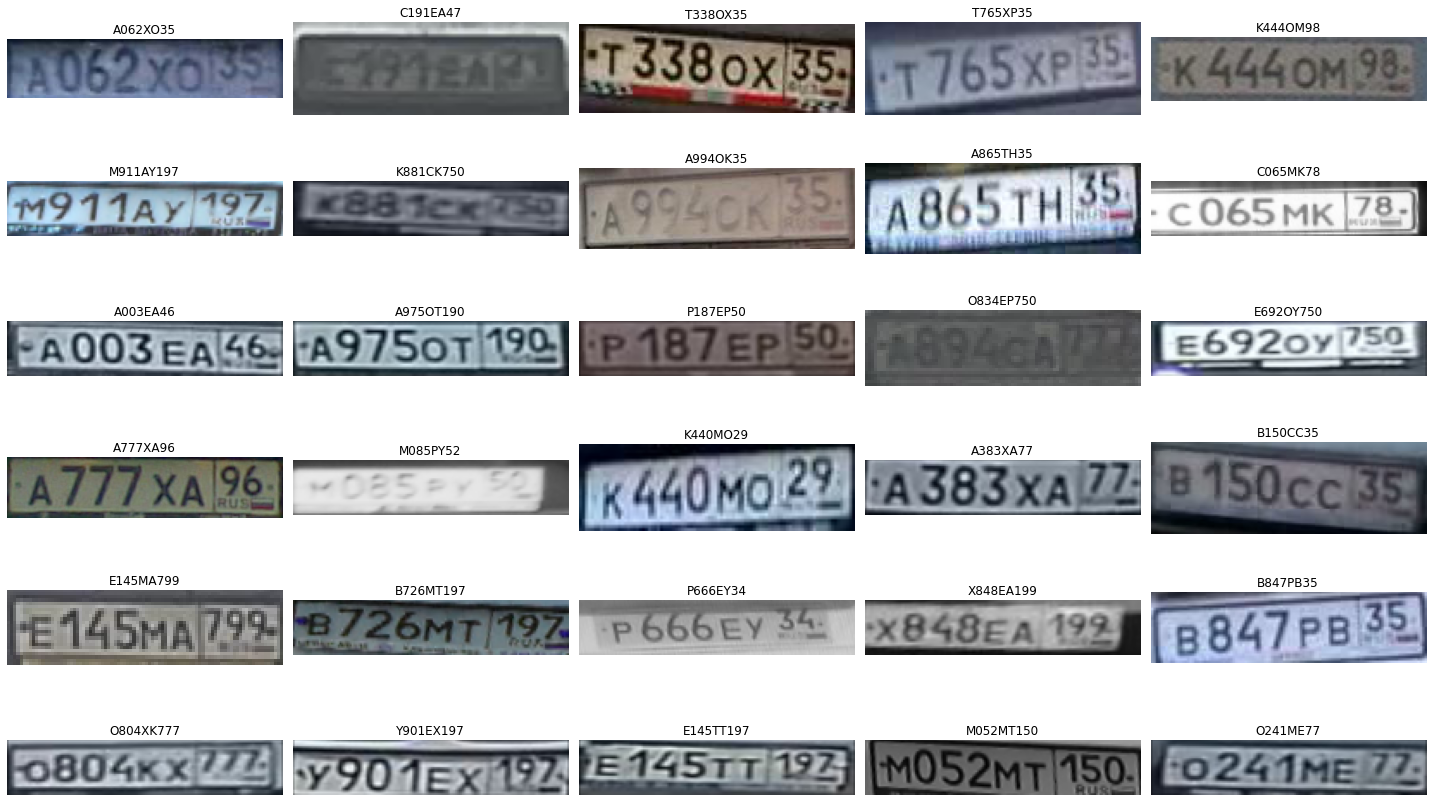

In [11]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config_train_simple), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config_train_simple[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

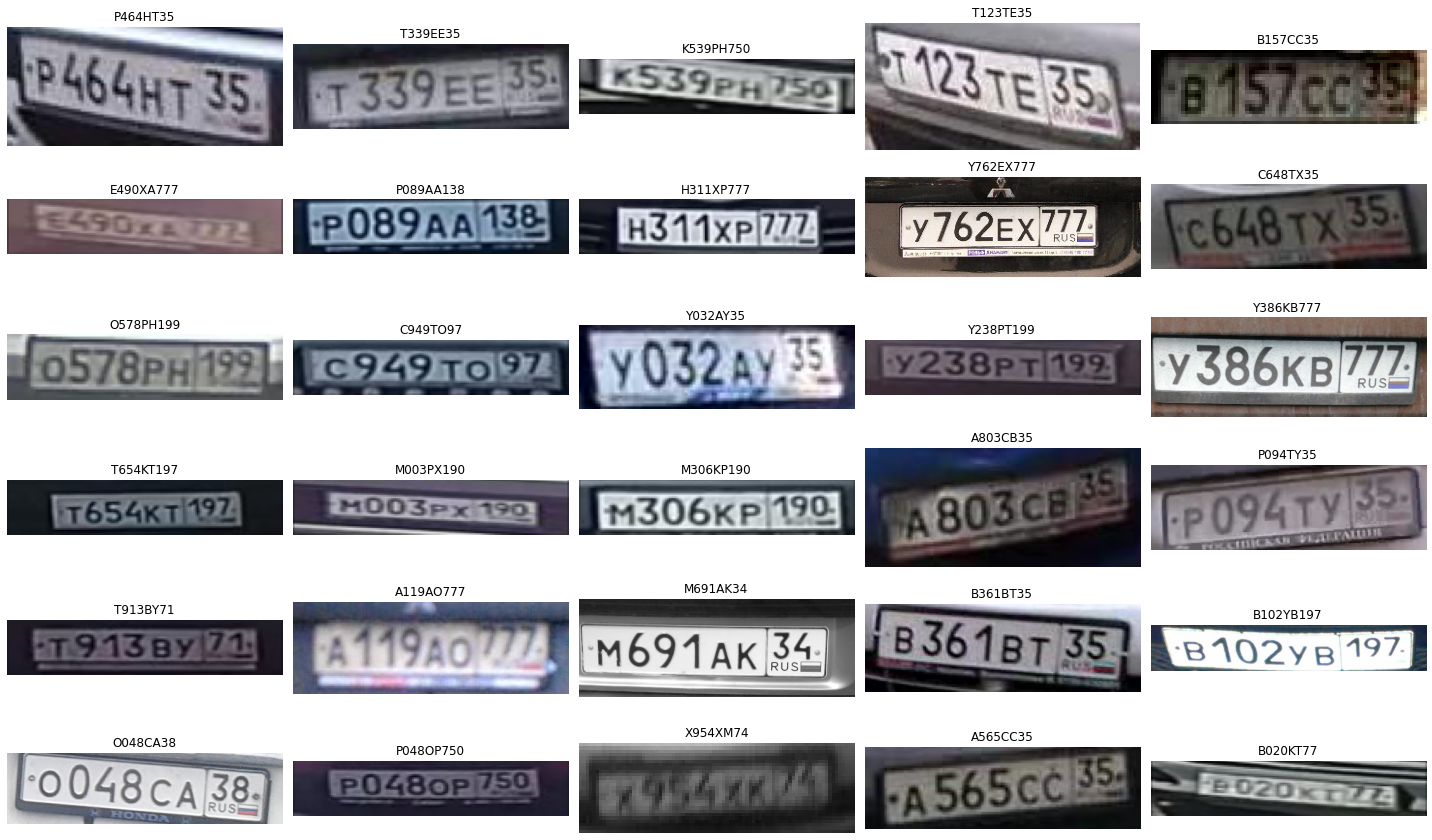

In [12]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config_train_complex), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config_train_complex[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [13]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера `HxWx3`).
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).
  
  


In [14]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        
        Args:
            - String of text.
            
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        
        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        # END OF YOUR CODE
        
        return seq

В качестве трансформации будем использовать только ресайз к фиксированному размеру `(320, 64)`. 
  
  *Не забудем про интерполяцию ([stackoverflow](https://stackoverflow.com/questions/3112364/how-do-i-choose-an-image-interpolation-method-emgu-opencv)).*

In [15]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        
        Returns: 
            Dict with image resized to self.size.
        """
        
        # YOUR CODE HERE
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        # END OF YOUR CODE
        
        return item

Соберем датасет вместе:

In [16]:
config = config_train_simple + config_train_complex 

In [17]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

In [18]:
x = dataset[0]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


Image shape: (64, 320, 3)
Seq: [13, 8, 3, 10, 13, 20, 8, 6, 1] Seq_len: 9
Text: E729ET750


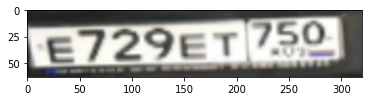

In [19]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

---

Текст номеров может иметь длину 8 (`LDDDLLDD`) или 9 (`LDDDLLDDD`), а класс `DataLoader` плохо справляется (из коробки) с данными переменного размера в одном батче. Однако, как увидим далее, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

*Здесь же реализовано преобразование `image` из формата `np.ndarray` в формат `torch.Tensor`.*

In [20]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [21]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [22]:
print("Image:"  , batch["image"  ].size())
print("Seq:"    , batch["seq"    ].size())
print("Seq:"    , batch["seq"    ])
print("Seq_len:", batch["seq_len"])
print("Text:"   , batch["text"   ])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([35])
Seq: tensor([13,  8,  3, 10, 13, 20,  8,  6,  1, 14,  6,  6,  8, 19, 20,  8,  8,  8,
        22, 10,  3,  5, 19, 14,  8,  8, 18, 10, 10,  1, 19, 11,  2,  8,  9],
       dtype=torch.int32)
Seq_len: tensor([9, 9, 8, 9], dtype=torch.int32)
Text: ['E729ET750', 'K557CT777', 'X924CK77', 'P990CA178']


# Построение модели

Начнем с построения `feature_extractor`. 

Для этого возьмем предобученную модель `ResNet18`, отрежем от нее последние два слоя (это `AdaptiveAvgPool2d` и `Linear`), оставив полносверточную часть. После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Для него мы сделаем пулинг по высоте (смотри параметры `self.pool`), превратив его в тензор размера `1x10`. 

Получим, что длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss` с таргетами длины 8 или 9). Используем трюк (в методе `apply_projection`), применив сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`.

In [23]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [24]:
feature_extractor = FeatureExtractor()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 20)

Итого, `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где 
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя `ResNet18`, т.е. 512), 
  - `L` - "длина последовательности" токенов (`self.output_len`).

---

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 


`GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности. 

In [26]:
class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [27]:
sequence_predictor = SequencePredictor(input_size=512, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [28]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 512)

In [29]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 23)

---

Теперь соберем две части в один класс CRNN.

In [30]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [31]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Проверим, как все работает на случайном тензоре:

In [32]:
crnn = CRNN()

In [33]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, 23)

In [34]:
decode(y, abc)

['T3T5TYTYCYTYTYTY']

### 5. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 6. Обучение и результаты

Можно выставить константу `ACTUALLY_TRAIN=False`, тогда вместо обучения будут загружены логи предварительно выполненного обучения.

In [35]:
ACTUALLY_TRAIN = True

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [36]:
crnn = CRNN()

Зададим гиперпараметры обучения:

In [37]:
num_epochs = 10
batch_size = 128
num_workers = 4

In [38]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [39]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [40]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [41]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Запустим обучение (при параметрах по умолчанию эпоха занимает ~22 секунды на GPU):

In [42]:
crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt,  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        print(i, np.mean(epoch_losses))
else:
    image_train_log = cv2.imread("./resources/train_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    with open("./data/crnn.pth.tar", "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

100%|██████████| 175/175 [00:34<00:00,  5.02it/s]


0 2.7440526853288922


100%|██████████| 175/175 [00:33<00:00,  5.21it/s]


1 1.4068218742098126


100%|██████████| 175/175 [00:32<00:00,  5.35it/s]


2 0.858390919821603


100%|██████████| 175/175 [00:32<00:00,  5.36it/s]


3 0.4369546593938555


100%|██████████| 175/175 [00:32<00:00,  5.31it/s]


4 0.13975727962596077


100%|██████████| 175/175 [00:33<00:00,  5.23it/s]


5 0.0676471368755613


100%|██████████| 175/175 [00:33<00:00,  5.29it/s]


6 0.04655636746968542


100%|██████████| 175/175 [00:32<00:00,  5.36it/s]


7 0.032749702307794774


100%|██████████| 175/175 [00:33<00:00,  5.30it/s]


8 0.03211791022547654


100%|██████████| 175/175 [00:32<00:00,  5.41it/s]

9 0.026703522998307434


Провалидируем:

In [43]:
crnn.eval()
if ACTUALLY_TRAIN:
    val_losses = []
    for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        val_losses.append(loss.item())

    print(np.mean(val_losses))
else:
    image_val_log = cv2.imread("./resources/val_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_val_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()

100%|██████████| 44/44 [00:06<00:00,  6.88it/s]

0.051035278138111935


Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

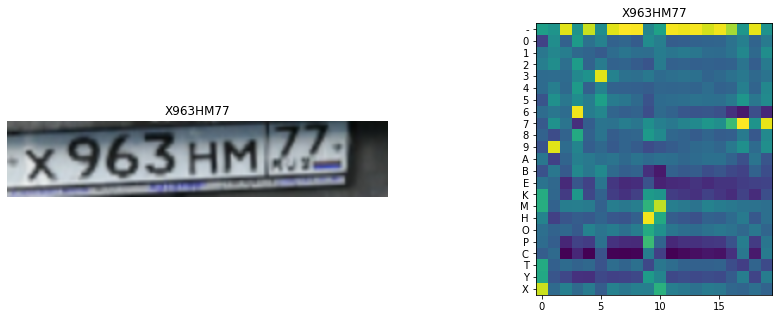

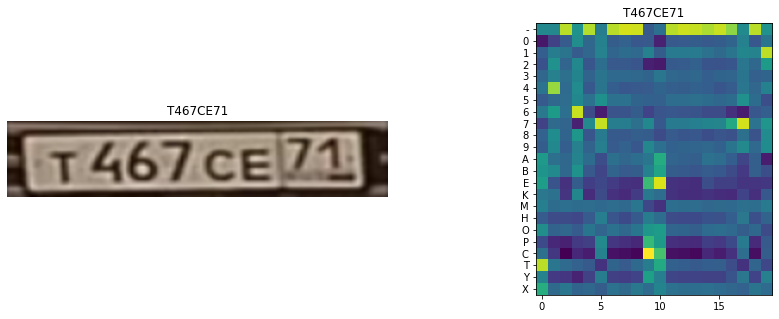

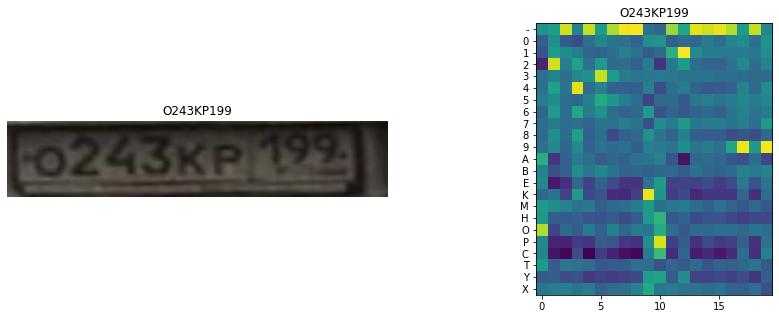

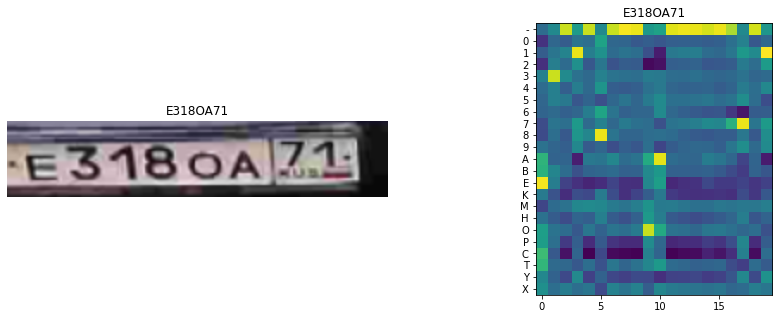

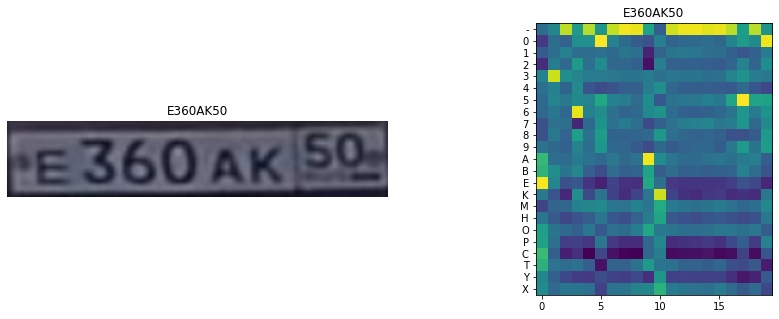

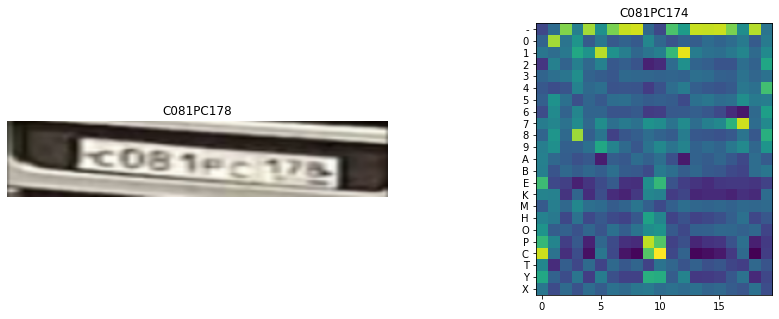

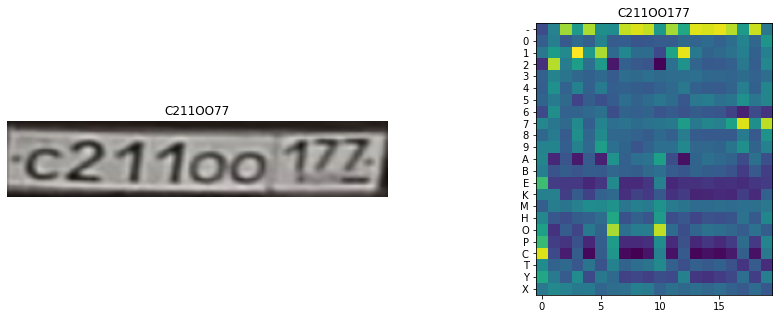

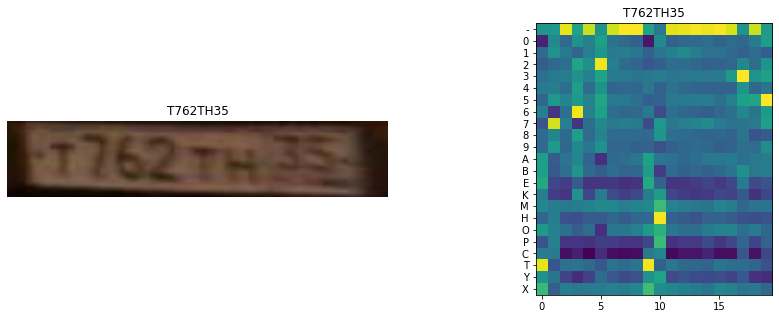

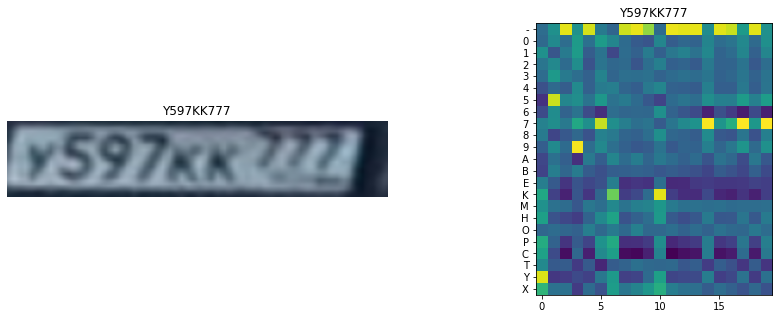

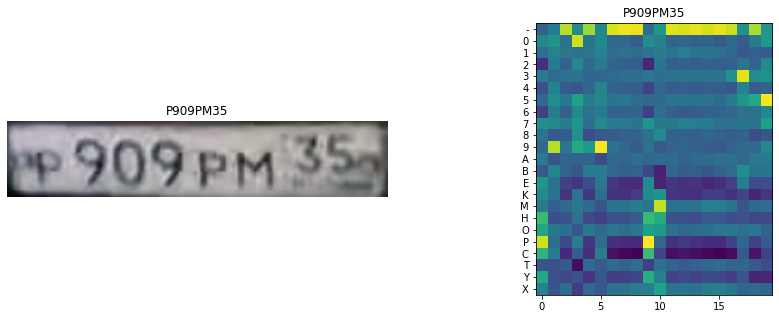

In [44]:
if ACTUALLY_TRAIN:
    y_ticks = ["-"] + [x for x in abc]

    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]

    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    for i in range(10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T

        plt.subplot(1, 2, 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.title(texts[i])

        plt.subplot(1, 2, 2)
        plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
        plt.title(texts_pred[i])

        plt.show()
else:
    for i in range(1, 11):
        
        image_val_log = cv2.imread(f"./resources/{str(i).zfill(2)}.png")
        plt.figure(figsize=(15, 8))
        plt.imshow(image_val_log[:, :, ::-1], interpolation="none")
        plt.axis("off")
        plt.show()

Обучимся теперь на всей выборке и с большим числом эпох

In [138]:
crnn = CRNN()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [139]:
num_epochs = 50
batch_size = 128
num_workers = 4

In [140]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [141]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [142]:
train_dataset = RecognitionDataset(config, transforms=Resize())

In [143]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [144]:
crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt,  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        print(i, np.mean(epoch_losses))
else:
    image_train_log = cv2.imread("./resources/train_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    with open("./data/crnn.pth.tar", "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

100%|██████████| 219/219 [00:41<00:00,  5.31it/s]


0 2.425552591341271


100%|██████████| 219/219 [00:45<00:00,  4.82it/s]


1 0.9371108156905327


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


2 0.27586386934535145


100%|██████████| 219/219 [00:40<00:00,  5.34it/s]


3 0.07215844747954853


100%|██████████| 219/219 [00:41<00:00,  5.26it/s]


4 0.04381117013763619


100%|██████████| 219/219 [00:41<00:00,  5.29it/s]


5 0.036697881551433914


100%|██████████| 219/219 [00:40<00:00,  5.40it/s]


6 0.030162807575269648


100%|██████████| 219/219 [00:39<00:00,  5.48it/s]


7 0.0255650442399799


100%|██████████| 219/219 [00:40<00:00,  5.43it/s]


8 0.023614984124762827


100%|██████████| 219/219 [00:40<00:00,  5.36it/s]


9 0.023396584099014055


100%|██████████| 219/219 [00:41<00:00,  5.31it/s]


10 0.023493117448707967


100%|██████████| 219/219 [00:40<00:00,  5.39it/s]


11 0.021318990990230345


100%|██████████| 219/219 [00:40<00:00,  5.40it/s]


12 0.018500639455282387


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


13 0.01651539783031769


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


14 0.014653877429579083


100%|██████████| 219/219 [00:40<00:00,  5.45it/s]


15 0.014148772194488271


100%|██████████| 219/219 [00:40<00:00,  5.42it/s]


16 0.01375939498004848


100%|██████████| 219/219 [00:40<00:00,  5.44it/s]


17 0.013144453700427732


100%|██████████| 219/219 [00:40<00:00,  5.47it/s]


18 0.015547443379022896


100%|██████████| 219/219 [00:41<00:00,  5.34it/s]


19 0.01688789306463648


100%|██████████| 219/219 [00:40<00:00,  5.45it/s]


20 0.011840017208378744


100%|██████████| 219/219 [00:40<00:00,  5.44it/s]


21 0.010368178440172855


100%|██████████| 219/219 [00:40<00:00,  5.43it/s]


22 0.009467611056391032


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


23 0.013341897214044175


100%|██████████| 219/219 [00:40<00:00,  5.46it/s]


24 0.014182177021436086


100%|██████████| 219/219 [00:39<00:00,  5.51it/s]


25 0.01287499333191748


100%|██████████| 219/219 [00:40<00:00,  5.46it/s]


26 0.008957911405040453


100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


27 0.008341835939312635


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


28 0.008472739964442914


100%|██████████| 219/219 [00:39<00:00,  5.48it/s]


29 0.011286515458678342


100%|██████████| 219/219 [00:40<00:00,  5.47it/s]


30 0.010613174250000688


100%|██████████| 219/219 [00:40<00:00,  5.44it/s]


31 0.011017250775287276


100%|██████████| 219/219 [00:41<00:00,  5.31it/s]


32 0.010703606073867921


100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


33 0.006893182684748208


100%|██████████| 219/219 [00:40<00:00,  5.41it/s]


34 0.00671363138321566


100%|██████████| 219/219 [00:40<00:00,  5.44it/s]


35 0.008387606102998739


100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


36 0.011550655961674575


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


37 0.010504024531734792


100%|██████████| 219/219 [00:40<00:00,  5.41it/s]


38 0.007477420666063689


100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


39 0.00408851605208514


100%|██████████| 219/219 [00:40<00:00,  5.44it/s]


40 0.003591662694882925


100%|██████████| 219/219 [00:40<00:00,  5.39it/s]


41 0.00462347847413799


100%|██████████| 219/219 [00:40<00:00,  5.46it/s]


42 0.012545558989694401


100%|██████████| 219/219 [00:40<00:00,  5.47it/s]


43 0.01662654677388943


100%|██████████| 219/219 [00:39<00:00,  5.48it/s]


44 0.009714355787951243


100%|██████████| 219/219 [00:40<00:00,  5.39it/s]


45 0.01142304515908366


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


46 0.008322705236182773


100%|██████████| 219/219 [00:40<00:00,  5.38it/s]


47 0.008909547787593447


100%|██████████| 219/219 [00:40<00:00,  5.42it/s]


48 0.007301392911861068


100%|██████████| 219/219 [00:40<00:00,  5.45it/s]

49 0.005143133075546354


# Результат на тестовой выборке

In [145]:
path_test = '/content/test/test'

In [146]:
config_test = os.listdir(path_test)
for i in np.arange(len(config_test)):
    config_test[i] = os.path.join(path_test,(str(i)+'.png'))

In [ ]:
config_test

In [150]:
size=(320, 64)

In [151]:
crnn.eval()

test_texts_pred = []
for item in tqdm.tqdm(config_test):
    # считаем и преобразуем входную картинку к нужному размеру
    interpolation = cv2.INTER_AREA if size[0] < (cv2.imread(item).astype(np.float32) / 255.).shape[1] else cv2.INTER_LINEAR
    image = cv2.resize(cv2.imread(item).astype(np.float32) / 255., size, interpolation=interpolation)
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    x = torch.unsqueeze(image, 0).to(device)
    with torch.no_grad():
        y = crnn(x).cpu()
    test_texts_pred.append(*(decode(y, crnn.alphabet)))

100%|██████████| 7012/7012 [00:40<00:00, 173.40it/s]


In [ ]:
test_texts_pred

In [114]:
import pandas as pd

In [153]:
submission = pd.read_csv('submission.csv', index_col = 'index')

In [154]:
submission['label'] = test_texts_pred

In [155]:
submission.head()

,label
index,
0,B620AE35
1,T955AC35
2,C245CH35
3,C191AA35
4,T524XT777


In [156]:
submission.to_csv("submission_2.csv")